In [1]:
%load_ext autoreload
%autoreload 2


from rpgm_algo import RpgAlgorithm
import numpy as np
import awesomeplot.core as ap
import scipy.sparse as sp

from gsc_libs import *

%matplotlib notebook

In [62]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, sp.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

def delete_rows_csc(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, sp.csc_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:, mask]
    
def project(g_orig, v_type, e_type):
    g = g_orig
    assert isinstance(g, RpgAlgorithm)
    vs = []
    es = []
    for k, v in g.edgelist():
        if not v_type[int(k)] == v_type[int(v)]:
            # add links from v to k
            g.adjacency[k,:] += g.adjacency[v,:]
            g.adjacency[:,k] += g.adjacency[:,v]
            g.adjacency[k, k] = 0
            # remove link between v and k
            g.adjacency.pop((k, v))
            #update coordinates etc.
            g.n -=1
            # update layers
            v_type[k] = max(v_type[k], v_type[v])
            # bookkeeping
            vs.append(v)
            es.append((k, v))
    #remove links from v
    g.adjacency = delete_rows_csr(g.adjacency.tocsr(), vs).tocsc()
    g.adjacency = delete_rows_csc(g.adjacency, vs).todok()
    # update coords
    g.lat = np.delete(g.lat, vs)
    g.lon = np.delete(g.lon, vs)
    g.locations = np.c_[g.lat, g.lon]
    v_type = np.delete(v_type, vs)
    #update e_type
    for k in e_type.keys():
        if k in es:
            e_type.pop(k, "error")
    
    return g, v_type, e_type
    
    

In [63]:
%%latex

Variant A: low-level grids are grown independently

<IPython.core.display.Latex object>

In [27]:
canvas = NeoNetPlot.paper(font_scale=3)
canvas.set_default_colours("discrete")
#c = np.copy(canvas.discrete_colours.colors)
#np.random.shuffle(c)
#canvas.dfcmp.colors = c

In [68]:
g, v_type, e_type = independent_layers(10, 15, 20, 6./10., 14./15., seed=42)
g, v_type, e_type = project(g, v_type, e_type)

esize = {}
for k, v in e_type.items():
    if v == 0:
        esize[k] = canvas.discrete_colours.colors[-2]
    else:
        esize[k] = "grey"

<IPython.core.display.Javascript object>


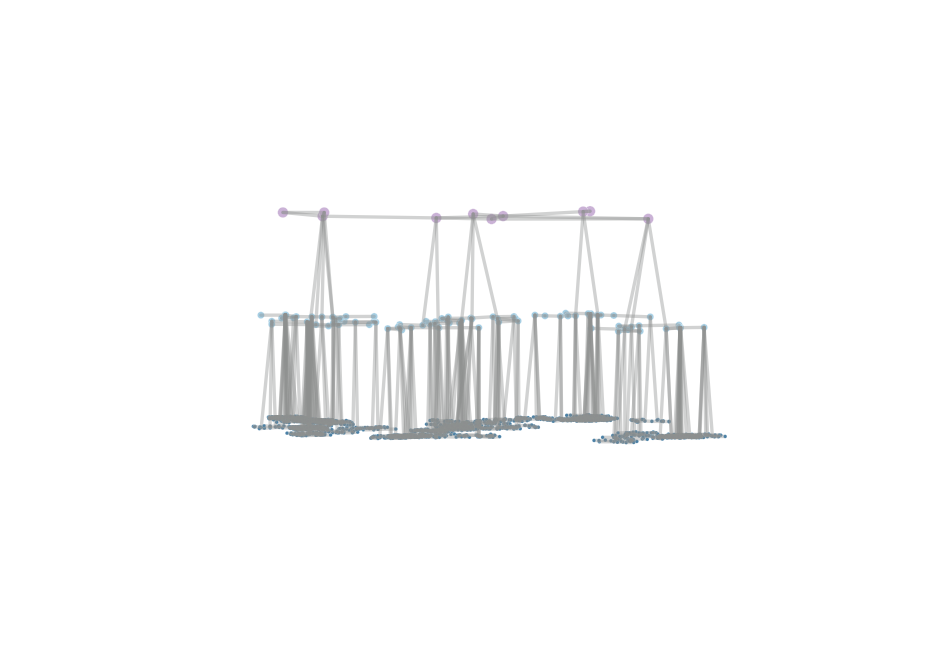

In [71]:
fig, ax = canvas.add_network(g.adjacency, 
                   styles={"layout": np.c_[g.lon, g.lat, v_type], 
                           "vertex_size":10.*v_type**2, 
                           "vertex_color":v_type-1,
                           #"edge_color_dict":esize
                          },
                   height=True
                  )
ax.view_init(elev=20, azim=-80)

<IPython.core.display.Javascript object>


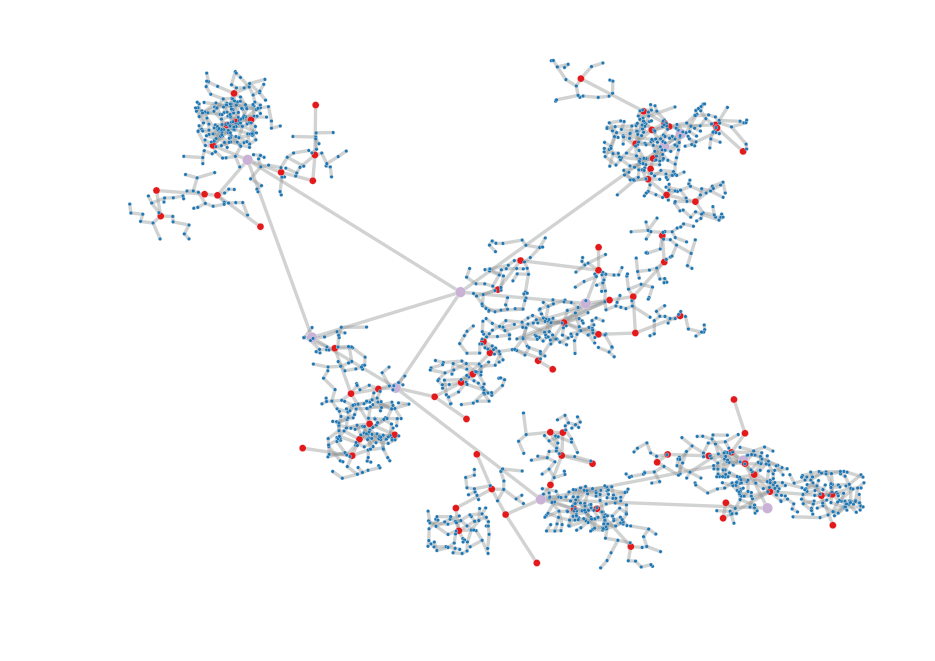

In [70]:
fig, ax = canvas.add_network(g.adjacency, 
                   styles={"layout": g.locations,  
                           "vertex_size":10.*v_type**2, 
                           "vertex_color": (v_type+2)**2/2.5 , 
                           #"edge_color_dict":esize
                          }
                  )

In [120]:
np.unique((v_type+2)**2/2.5)


array([  3.6,   6.4,  10. ])

In [ ]:
canvas.save(["gsc_3d", "gsc_2d"])

In [36]:
%%latex

Statistics

<IPython.core.display.Latex object>

In [35]:
def df_from_dict(dic):
    from pandas import DataFrame
    return DataFrame(data=dic)

def merge(li):
    from pandas import concat
    return concat(li)

def sparse_from_dict(dic):
    shape = list(np.repeat(np.asarray(dic.keys()).max() + 1,2))
    return sp.csr_matrix((dic.values(), zip(*dic.keys())), shape = shape)
    

In [81]:
names = np.array(["low", "middle", "high"])

nodes = []
links = []

for sample in range(50):    
    g, v_type, e_type = independent_layers(10, 15, 12, 6./10., 14./15., seed=sample)
    g, v_type, e_type = project(g, v_type, e_type)
    print sample,
    
    dmatrix = sparse_from_dict({k: 1./v**2 for k,v in g.distance.items()})
    ndict = {"degree":[], "strength":[], "level":[]}
    edict = {"link_length":[], "level":[]}
    
    for (k, v) in enumerate(v_type):
        ndict["degree"].append(g.adjacency[k, :].sum())
        ndict["strength"].append(dmatrix[k, :].sum())
        ndict["level"].append(names[v-1]) 
        
    nodes.append(df_from_dict(ndict))
    
    for (k, v) in e_type.items():
        if v > 0:
            edict["link_length"].append(g.distance[k])
            edict["level"].append(names[v-1])
        else:
            pass
            #edict["link_length"].append(np.nan)
            #edict["level"].append("transformer")

    links.append(df_from_dict(edict))

0

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


In [73]:
import pandas as pd


In [82]:
dfn = pd.concat(nodes)
dfe = pd.concat(links)

In [83]:
# save data for later
dfn.to_pickle("nodes_gsc_projection")
dfe.to_pickle("links_gsc_projection")

In [16]:
dfn = pd.read_pickle("nodes_gsc")
dfe = pd.read_pickle("links_gsc")

In [84]:
dfn.columns = pd.Index([u'degree', u'level', u'density'], dtype='object')

In [85]:
dfe["loglength"] = np.log10(dfe.link_length)

In [86]:
import matplotlib.pyplot as plt
import seaborn

def level_hist(df, col, bins, cmap=None):
    df_t = df.copy()
    df_t['factor'] = pd.cut(df[col], len(bins))
    df_p = (df_t[['factor','level']]
            .pivot_table(columns='level',index='factor',aggfunc=len,fill_value=0)
            .reset_index())
   
    fig = df_p[['factor', "low", "middle", "high"]].plot(kind='bar',
                                                       stacked=True,
                                                       x="factor",
                                                       log=True,
                                                        color=cmap
                                                            )
    ax = fig.get_axes()
    ax.set_xlabel(col)
    l = len(ax.get_xticks())
    ax.set_xticklabels(bins[:min(l, len(bins))])
    return fig

def level_scatter(df, x, y, cmap=None):
    
    groups = df.groupby('level')

    # Plot
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    counter = 0
    for name, group in groups:
        ax.semilogy(group[x], group[y], marker='o', c=cmap[counter], alpha=0.3, linestyle='', ms=12, label=name)
        counter += 1
    ax.legend()
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    return fig

<IPython.core.display.Javascript object>


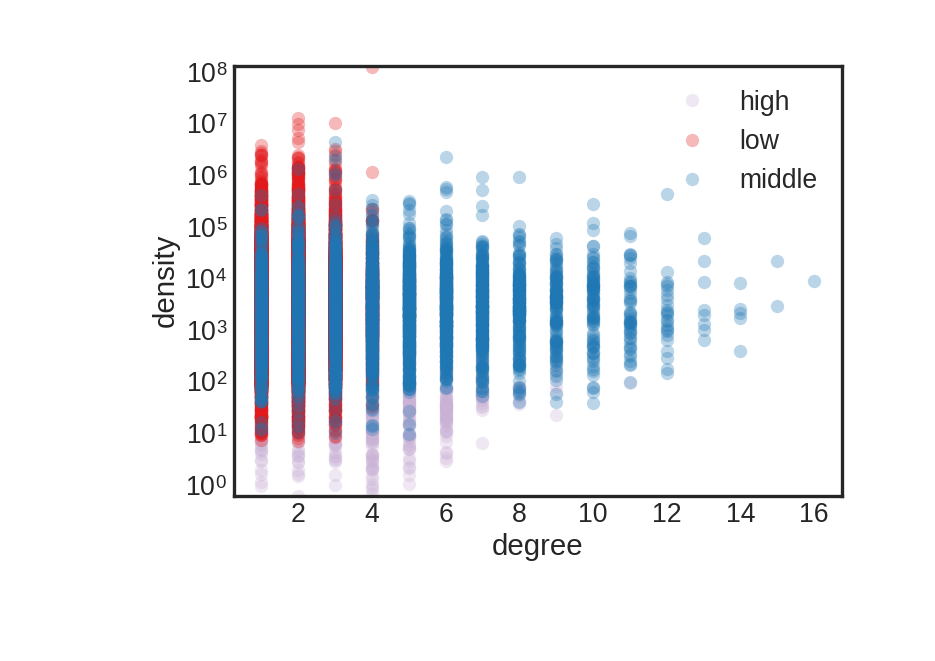

In [87]:
fig = level_scatter(dfn, x="degree", y="density", cmap=canvas.discrete_colours.colors[[9, 4, 0]])
plt.subplots_adjust(bottom=.25, left=.25)
plt.savefig("gsc_density_vs_degree.png")

<IPython.core.display.Javascript object>


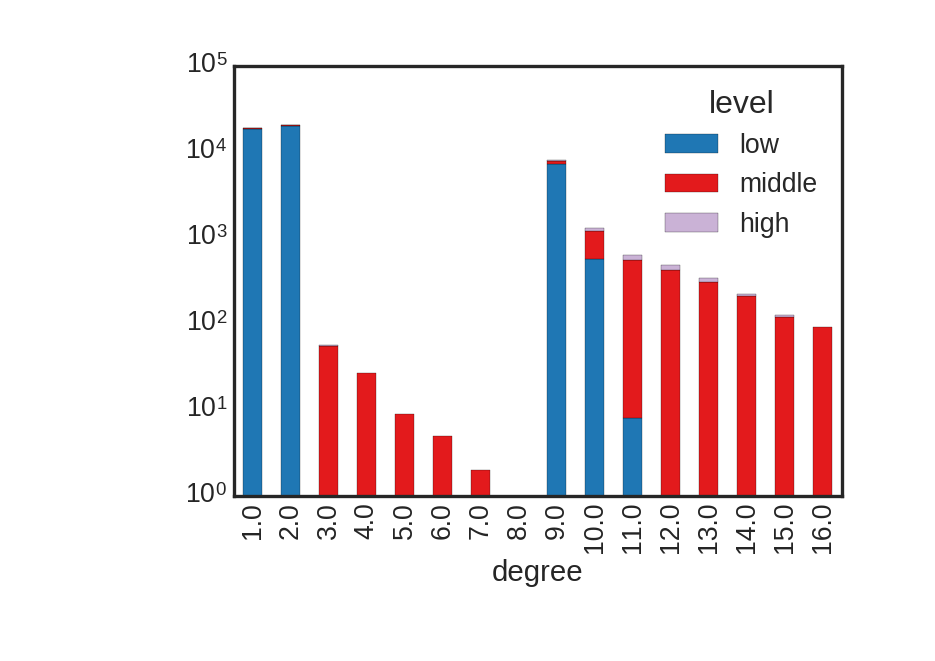

In [88]:
bins = np.linspace(np.min(dfn.degree), np.max(dfn.degree), np.max(dfn.degree), endpoint=True)
fig = level_hist(dfn, "degree", bins, cmap=canvas.discrete_colours.colors[[0, 4, 9]])
plt.subplots_adjust(bottom=.25, left=.25)
plt.savefig("gsc_degree_log.pdf")

<IPython.core.display.Javascript object>


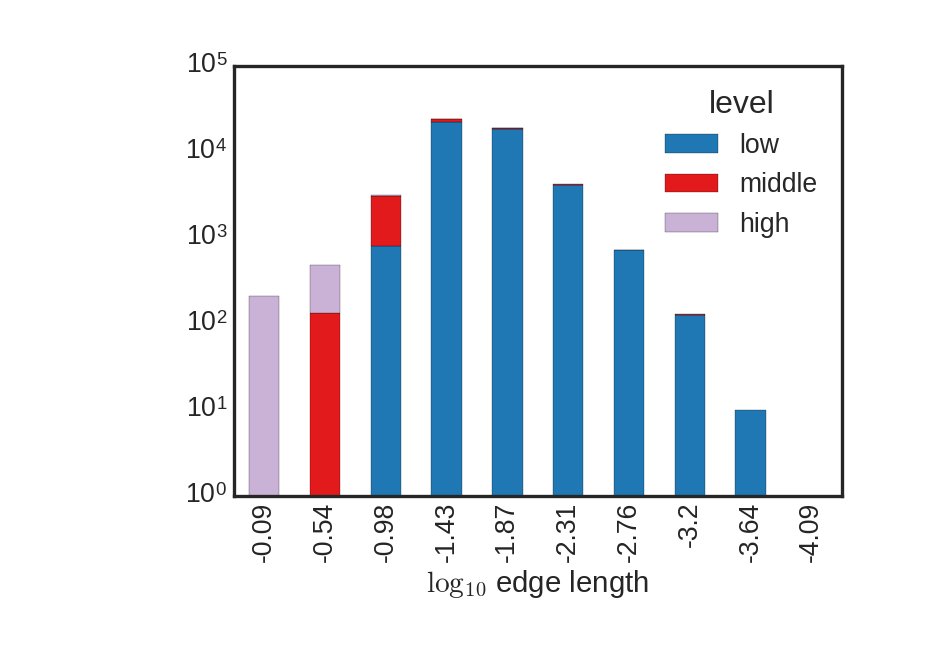

In [89]:
bins = np.around(np.linspace(np.min(dfe.loglength), np.max(dfe.loglength), 10, endpoint=True), 2)[::-1]
fig = level_hist(dfe, "loglength", bins,  cmap=canvas.discrete_colours.colors[[0, 4, 9]])
ax = fig.get_axes()
ax.set_xlabel(r"$\log_{10}$ edge length")
plt.subplots_adjust(bottom=.25, left=.25)
plt.savefig("gsc_loglength.pdf")

<IPython.core.display.Javascript object>


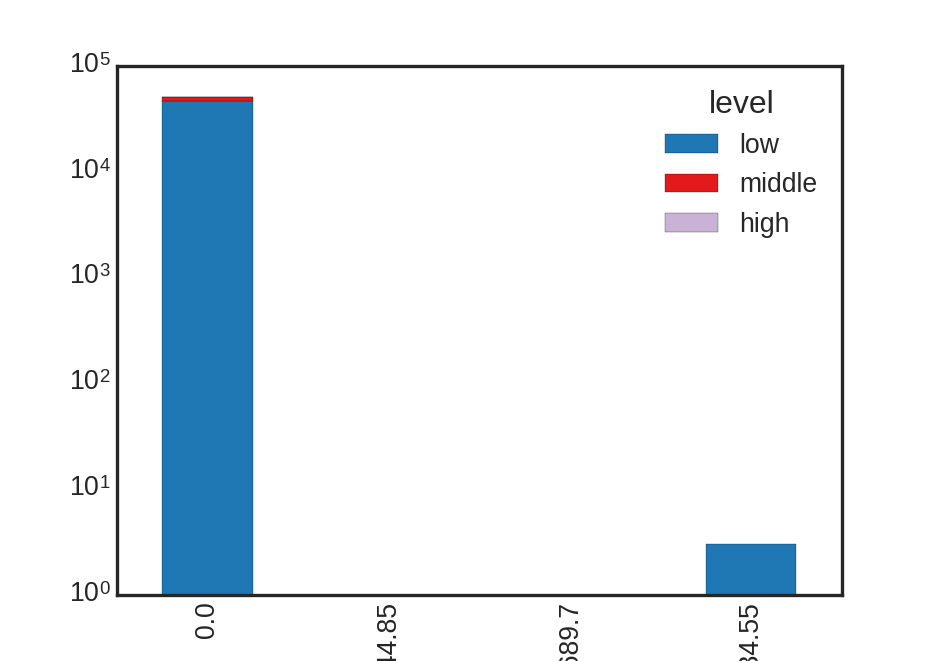

In [90]:
bins = np.around(np.linspace(np.min(dfn.density), np.max(dfn.density), 20, endpoint=True), 2)
level_hist(dfn, "density", bins,  cmap=canvas.discrete_colours.colors[[0, 4, 9]])

In [ ]:
admittance = {k: - np.array(v) for k,v in link_length.items()}

In [ ]:
fig3 = canvas.add_hist(nodes.strength, label=r"node strength", log=True, nbins=20)
#fig4 = canvas.add_scatterplot(nodes, "degree", "strength")

In [ ]:
canvas.add_scatterplot(nodes.degree, nodes.strength)

<IPython.core.display.Javascript object>


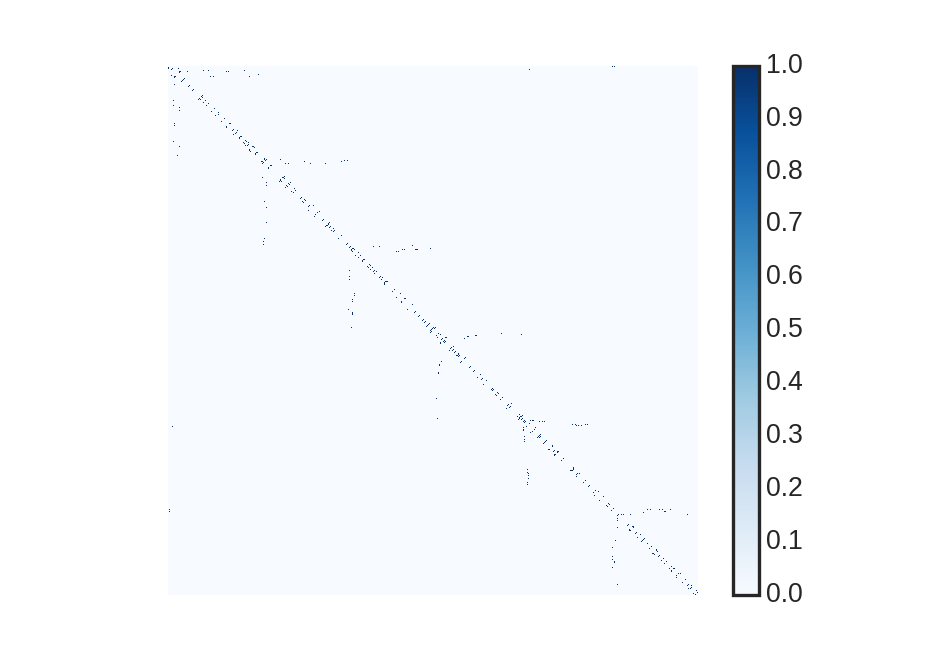

In [94]:
# the matrix is extremely sparse

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(g.adjacency.todense(), cmap=plt.get_cmap('Blues'), interpolation='nearest',
               vmin=0, vmax=1)
fig.colorbar(im)
plt.axis("off")
plt.show()



%%latex

Variant B: grids of the same level are grown simultaneously

np.random.seed(1)
debug = 0

pars = Parameters(n=10, n0=8)
loc = centered_coords(pars.n, pars.centre, pars.boundaries)
g = network(pars, loc)


if debug:
    print "HV"
    print g

# for plotting ...
vsize = 100. * np.ones(g.n)

transformers = np.random.choice(range(g.n), size=6, replace=False)
transformers_mv_hv = np.arange(60)[::10]

nodes = []
for i, t in enumerate(transformers):

    pars = Parameters.mv(centre=g.locations[t])
    loc = centered_coords(pars.n, pars.centre, pars.boundaries)
    nodes.append(loc)
    
    if debug:
        print "MV @", t, g.locations[t]
    
    vsize = np.append(vsize, 50. * np.ones(pars.n))
    
locs = np.concatenate(nodes)
pars = Parameters(n=len(locs), n0=1, boundaries=[1, 1], q=0, p=0, r=0, s=0, grow=True)
g_mv = network(pars, locs) 

if debug:
    print "MV"
    print g_mv

mv_nodes = range(g.n, g.n + 6 * Parameters.mv(0).n)
# do not pick nodes with hv/mv transformer again
mv_nodes = list(set(mv_nodes).difference(transformers_mv_hv))
    
append_net(g, g_mv, zip(transformers, transformers_mv_hv))

transformers_mv_lv = np.random.choice(mv_nodes, size=6*4, replace=False)

nodes = []
for i, t in enumerate(transformers_mv_lv):
    pars = Parameters.lv(centre=g.locations[t])
    loc = centered_coords(pars.n, pars.centre, pars.boundaries)
    nodes.append(loc)
    
    if debug:
        print "LV @", t, g.locations[t]
    
    vsize = np.append(vsize, 10. * np.ones(pars.n))
    
locs = np.concatenate(nodes)
pars = Parameters(n=len(locs), n0=1, boundaries=[.5, .5], q=0, p=0, r=0, s=0, grow=True)
g_lv = network(pars, locs) 

if debug:
    print "LV"
    print g_lv

transformers_lv = np.arange(60)[::5]

append_net(g, g_lv, zip(transformers_mv_lv, transformers_lv))

esize = {}
for edge in g.edgelist():
    if vsize[edge[0]] == vsize[edge[1]]:
        esize[edge] = "grey"
    else:
        esize[edge] = "y"

canvas = NeoNetPlot.paper()
canvas.set_default_colours("discrete")
fig = canvas.add_network(g.adjacency, 
                   styles={"layout": np.c_[g.locations, vsize], 
                           "vertex_size":10.*np.sqrt(vsize), 
                           "vertex_color":vsize, 
                           "edge_color_dict":esize},
                   height=True
                  )

canvas.save(["gsc_simultaneous_networks"])

%%latex

Intermezzo: model parameters

# additional links in intit phase
np.random.seed(42)
pars = Parameters(n=100, n0=100, s=0.5, q=0.1, p=0, r=1)
m = min(int(pars.n0 * (1. - pars.s) * (pars.p + pars.q)), (pars.n0 - 1) * (pars.n0 - 2) / 2.)
print m

loc = centered_coords(pars.n, pars.centre, pars.boundaries)

g = RpgAlgorithm()
g.debug = True
g.low_memory = False
g.set_params(n=pars.n, n0=pars.n0, r=pars.r, p=pars.p, q=pars.q, s=pars.s)
g.setup_locations(sampling="data", locations=loc)
%time g.initialise()

degrees = np.squeeze(g.adjacency.sum(axis = 1))

canvas = ap.Plot()
fig = canvas.add_network(g.adjacency, styles={"layout": g.locations}, vertex_labels=range(g.n))
fig = canvas.add_hist(degrees, nbins=4)